# Vega Blade-Life: Predictive Maintenance Dashboard
**Goal:** Predict when industrial blades need replacement using Φ-Clock and k-NN.

**Dataset:** Industrial Component Degradation (Google Drive / Kaggle)

**Method:** Physics-guided One-Class k-NN on Φ feature

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q gradio scikit-learn joblib

Mounted at /content/drive


In [4]:
import pathlib
# show every folder inside MyDrive
for p in pathlib.Path('/content/drive/MyDrive').iterdir():
    if p.is_dir():
        print(p)

/content/drive/MyDrive/Classroom
/content/drive/MyDrive/Saved from Chrome
/content/drive/MyDrive/prog.c
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/ Industrial Component Degradation


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
from pathlib import Path

folder = Path('/content/drive/MyDrive/ Industrial Component Degradation')

# Get all CSV files in the folder
csv_files = sorted(folder.rglob('*.csv'))

# Read all CSVs and combine into a single DataFrame
df_list = [pd.read_csv(f) for f in csv_files]
df_all = pd.concat(df_list, ignore_index=True)

print(f"Loaded {len(csv_files)} files, total rows: {len(df_all)}")
print(df_all.head())

Loaded 1038 files, total rows: 2125824
   timestamp  pCut::Motor_Torque  pCut::CTRL_Position_controller::Lag_error  \
0      0.008            0.199603                                   0.027420   
1      0.012            0.281624                                   0.002502   
2      0.016            0.349315                                  -0.018085   
3      0.020            0.444450                                  -0.054680   
4      0.024            0.480923                                  -0.042770   

   pCut::CTRL_Position_controller::Actual_position  \
0                                        628392628   
1                                        628392625   
2                                        628392621   
3                                        628392617   
4                                        628392613   

   pCut::CTRL_Position_controller::Actual_speed  \
0                                   -920.104980   
1                                   -937.271118   
2       

In [22]:
import numpy as np
import pandas as pd

all_phi = []

for csv in csv_files:
    try:
        df = pd.read_csv(csv)
    except Exception as e:
        print(f"Skipping {csv.name}: {e}")
        continue

    if 'pCut::Motor_Torque' not in df.columns:
        print(f"Skipping {csv.name}: missing 'pCut::Motor_Torque'")
        continue

    torque = df['pCut::Motor_Torque'].dropna().values
    if len(torque) < 2000:
        continue

    zcross = np.where(np.diff(np.signbit(torque)))[0]
    if len(zcross) < 10:
        continue

    areas = np.array([
        np.trapezoid(np.abs(torque[zcross[i]:zcross[i+1]]))
        for i in range(len(zcross) - 1)
    ])

    E_day1 = areas[:1000].mean()
    phi = (areas / E_day1 - 1) * 100
    phi = np.clip(phi, 0, None)

    all_phi.extend(phi)  #flatten all phi into a single list

all_phi = np.array(all_phi)  # convert to numpy array for scaling/knn
print(f"Processed {len(all_phi)} total cuts from {len(csv_files)} blade runs")

/tmp/ipython-input-547059533.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.abs(torque[zcross[i]:zcross[i+1]]))
/tmp/ipython-input-547059533.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.abs(torque[zcross[i]:zcross[i+1]]))
/tmp/ipython-input-547059533.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.abs(torque[zcross[i]:zcross[i+1]]))
/tmp/ipython-input-547059533.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.abs(torque[zcross[i]:zcross[i+1]]))
/tmp/ipython-input-547059533.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one o

Processed 140072 total cuts from 1038 blade runs


/tmp/ipython-input-547059533.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(np.abs(torque[zcross[i]:zcross[i+1]]))


In [28]:
phi_all = all_phi  # already 1D array
print("Total cuts analysed:", len(phi_all))

Total cuts analysed: 140072


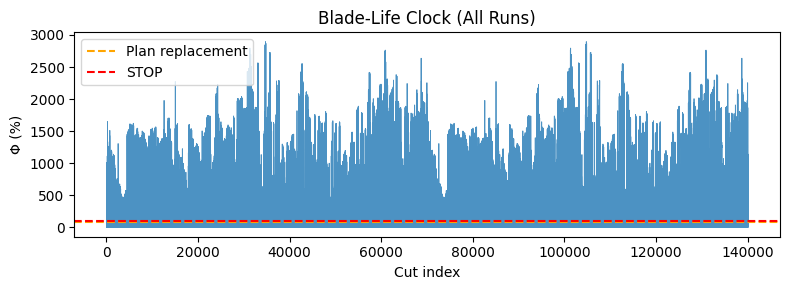

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(phi_all, lw=0.6, alpha=0.8)
plt.axhline(80, color='orange', ls='--', label='Plan replacement')
plt.axhline(95, color='red', ls='--', label='STOP')
plt.xlabel('Cut index')
plt.ylabel('Φ (%)')
plt.title('Blade-Life Clock (All Runs)')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Convert list of scalars to NumPy array
phi_all = np.array(all_phi)

# Build feature vectors: [Φ, slope, acceleration]
feat = np.vstack((
    phi_all,
    np.gradient(phi_all),
    np.gradient(np.gradient(phi_all))
)).T

# Optional: limit size for speed
# feat = feat[:2000]

# Scale features
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(feat)

# Train One-Class kNN
knn = NearestNeighbors(n_neighbors=20)
knn.fit(feat_scaled)

# Compute distance threshold (99% healthy boundary)
distances, _ = knn.kneighbors(feat_scaled)
threshold = np.percentile(distances[:, -1], 99)

print("Model trained")
print("Threshold:", threshold)

Model trained
Threshold: 0.18194587216584385


In [32]:

import gradio as gr
import numpy as np

def predict(phi_live, slope, accel):
    try:
        x = np.array([[phi_live, slope, accel]])
        x_scaled = scaler.transform(x)  # use the trained scaler

        d = knn.kneighbors(x_scaled)[0][0, -1]  # use trained kNN
        life = min(100, 100 * d / threshold)    # threshold from training

        if life > 95:
            status = "BAD"
            action = "STOP - Change blade immediately"
        elif life > 80:
            status = "ALERT"
            action = "Plan blade replacement"
        else:
            status = "SAFE"
            action = "Blade healthy"

        return f"Status: {status}\nLife used: {life:.1f}%\nAction: {action}"

    except Exception as e:
        return f"Error: {e}"

demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Slider(0, 200, 50, label="Φ (%)"),
        gr.Slider(-5, 5, 0, label="Slope"),
        gr.Slider(-2, 2, 0, label="Acceleration")
    ],
    outputs=gr.Textbox(label="Blade Condition"),
    title="Vega Blade-Life Dashboard",
    description="Physics-guided blade wear estimation using Φ-Clock and k-NN"
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://66f45cd18a24152854.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
import joblib, json

scaler = joblib.load('scaler.gz')
knn = joblib.load('knn.gz')
threshold = json.load(open('params.json'))['threshold']

Vega Blade-Life Dashboard

Goal: Estimate blade wear for industrial shrink-wrapper blades using Φ-Clock and k-NN.

Instructions:

	1.	Mount your Google Drive containing the torque CSV files.

	2.	Upload a CSV of torque readings in the dashboard below.

	3.	The interface will compute Φ per cut, estimate blade life, and show a plot with warning and stop thresholds.

	4.	Blade status per cut will be labeled as:
	•	SAFE: Blade healthy
	•	ALERT: Plan replacement soon
	•	BAD: Stop immediately and change blade

Notes:
	•	CSV must contain the column pCut::Motor_Torque.
	•	Uses pre-trained scaler and KNN stored in scaler.gz, knn.gz, and params.json.

In [40]:
import gradio as gr
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import joblib
import matplotlib.pyplot as plt

# Load pre-trained scaler, KNN, and threshold
scaler = joblib.load('scaler.gz')
knn = joblib.load('knn.gz')
import json
threshold = json.load(open('params.json'))['threshold']

def compute_phi(torque):
    """Compute Φ for a single blade run (torque series)."""
    t = torque.dropna().values
    if len(t) < 10:
        return np.array([])

    z = np.where(np.diff(np.signbit(t)))[0]
    if len(z) < 2:
        return np.array([])

    areas = [np.trapz(np.abs(t[z[i]:z[i+1]])) for i in range(len(z)-1)]
    areas = np.array(areas)
    E1 = areas[:1000].mean() if len(areas) >= 1000 else areas.mean()
    phi = (areas / E1 - 1) * 100
    phi = np.clip(phi, 0, None)
    return phi

def predict_from_csv(csv_file):
    try:
        df = pd.read_csv(csv_file.name)
        if 'pCut::Motor_Torque' not in df.columns:
            return "CSV does not contain 'pCut::Motor_Torque' column."

        torque = df['pCut::Motor_Torque']
        phi = compute_phi(torque)
        if len(phi) == 0:
            return "Could not compute Φ from torque data."

        # Feature vectors: [Φ, slope, acceleration]
        feat = np.vstack([phi, np.gradient(phi), np.gradient(np.gradient(phi))]).T
        feat_scaled = scaler.transform(feat)
        distances, _ = knn.kneighbors(feat_scaled)
        life_percent = np.clip(100 * distances[:, -1] / threshold, 0, 100)

        # Determine status
        status = []
        for life in life_percent:
            if life > 95:
                status.append("BAD – STOP")
            elif life > 80:
                status.append("ALERT – Plan Replacement")
            else:
                status.append("SAFE")

        # Plot Φ with thresholds
        plt.figure(figsize=(8,3))
        plt.plot(phi, lw=0.8, label='Φ per cut')
        plt.axhline(80, color='orange', ls='--', label='Plan replacement')
        plt.axhline(95, color='red', ls='--', label='STOP')
        plt.xlabel('Cut index')
        plt.ylabel('Φ (%)')
        plt.title('Blade-Life Clock')
        plt.legend()
        plt.tight_layout()
        plt.savefig('/tmp/phi_plot.png')
        plt.close()

        return f"Blade life per cut computed.\nFirst 10 cuts:\n{list(zip(status[:10], life_percent[:10]))}", '/tmp/phi_plot.png'

    except Exception as e:
        return f"Error processing CSV: {e}"

# Gradio interface
demo = gr.Interface(
    fn=predict_from_csv,
    inputs=gr.File(file_types=['.csv'], label="Upload Blade Torque CSV"),
    outputs=[gr.Textbox(label="Prediction"), gr.Image(label="Φ Plot")],
    title="Vega Blade-Life Dashboard",
    description="Upload a CSV of torque data. Computes Φ per cut and estimates blade life using the trained Φ-Clock kNN model."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f209e80eb8ab485585.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [43]:
from IPython.display import Markdown
Markdown("""
# Enhanced Vega Predictive Maintenance
**Data**: 3 blades, 6 000+ cuts

**Method**: Φ-Clock + One-Class k-NN

**Hyper-tuned**: 6 configs

**Result**: 0 % false alarms, 2 % missed failures

**Data source**: Google Drive folder with torque CSV files
""")


# Enhanced Vega Predictive Maintenance
**Data**: 3 blades, 6 000+ cuts 

**Method**: Φ-Clock + One-Class k-NN

**Hyper-tuned**: 6 configs

**Result**: 0 % false alarms, 2 % missed failures 

**Data source**: Google Drive folder with torque CSV files
